<a href="https://colab.research.google.com/github/dtabuena/Workshop/blob/main/Gain_Rheo_Anim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
'Get Standard Modules'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import os
from scipy.signal import butter,filtfilt
from tqdm import tqdm
import warnings
from IPython.display import clear_output
from datetime import datetime
import sys
import warnings
import shutil
from google.colab import files
import matplotlib as mpl
warnings.filterwarnings('ignore')
np.set_printoptions(threshold=sys.maxsize)
clear_output(wait=False)



!pip install openpyxl --quiet
!pip install XlsxWriter --quiet


'''Get Repositories'''
try: shutil.rmtree('/content/EphysLib')
except: None

"run dtabuena's ephys notebooks"
try: shutil.rmtree('/content/CrispyMice')
except: None
# !git clone https://github.com/dtabuena/CrispyMice
# to_import = ['CrispyPipelineFuncs.ipynb']
# for i in to_import:
#     f = '/content/CrispyMice/' + i
#     %run $f
!git clone https://github.com/dtabuena/EphysLib
to_import = [
            'ABF_Quality_Control.ipynb',
            'Basic_Ephys.ipynb',
            'Simple_ABF_tools.ipynb',
            'fun_math.ipynb',
            'importing_abfs_from_dropbox.ipynb',
            'QC_recoding_dataframe.ipynb',
            'Analyzers/input_resistance_analyzer.ipynb',
            'Analyzers/gain_analyzer.ipynb',
            'Analyzers/latencey_analyzer.ipynb',
            'Analyzers/IV_analyzer.ipynb',
            'Analyzers/Vm_analyzer.ipynb',
            'Analyzers/membrane_analyzer.ipynb',
            'Analyzers/rheobase_analyzer.ipynb',
            'Ephys_wrapper.ipynb',
            ]
for i in to_import:
    f = '/content/EphysLib/' + i
    %run $f


Cloning into 'EphysLib'...
remote: Enumerating objects: 1077, done.
remote: Counting objects: 100% (454/454), done.
remote: Compressing objects: 100% (261/261), done.
remote: Total 1077 (delta 330), reused 230 (delta 193), pack-reused 623
Receiving objects: 100% (1077/1077), 17.41 MiB | 11.25 MiB/s, done.
Resolving deltas: 100% (707/707), done.


In [11]:

import urllib.request
file_link = 'https://www.dropbox.com/scl/fi/p5vny9fsmonwbsm74a5k7/2022x10x28_NEL2_E4KI_F_P258_s001_c001_CA3xPOS_0008.abf?rlkey=xr0y9rw0dmoynnsp38idiemii&dl=1'
filename = './2022x10x28_NEL2_E4KI_F_P258_s001_c001_CA3xPOS_0008.abf'
urllib.request.urlretrieve(file_link, filename)

('./2022x10x28_NEL2_E4KI_F_P258_s001_c001_CA3xPOS_0008.abf',
 <http.client.HTTPMessage at 0x790b74f81c00>)

In [12]:
def set_font_all(FS):

    # get arial
    import matplotlib as mpl
    import urllib.request
    arial_link = 'https://raw.githubusercontent.com/dtabuena/Resources/main/Fonts/arial.ttf'
    filename = './arial.ttf'
    urllib.request.urlretrieve(arial_link, filename)
    mpl.font_manager.fontManager.addfont(filename)

    plt.rcParams.update({'font.size': FS, 'font.family': 'arial','axes.linewidth':.5,
                         'xtick.major.width': 0.5,'ytick.major.width': 0.5,
                         'figure.titlesize':FS,'axes.titlesize': FS,'xtick.labelsize': FS,
                         'ytick.labelsize': FS,'axes.labelsize': FS,'legend.fontsize': FS})
    return None
set_font_all(8)

1
[0.7966 0.7275 0.1742 1.    ]
[0.707  0.6402 0.2661 1.    ]
[0.6122 0.563  0.3285 1.    ]
[0.5186 0.4884 0.3638 1.    ]
[0.4322 0.4208 0.3777 1.    ]
[0.3508 0.3541 0.3619 1.    ]
[0.2738 0.292  0.3428 1.    ]
[0.1847 0.2289 0.3388 1.    ]
r
[0.     0.1081 0.2438 1.    ]


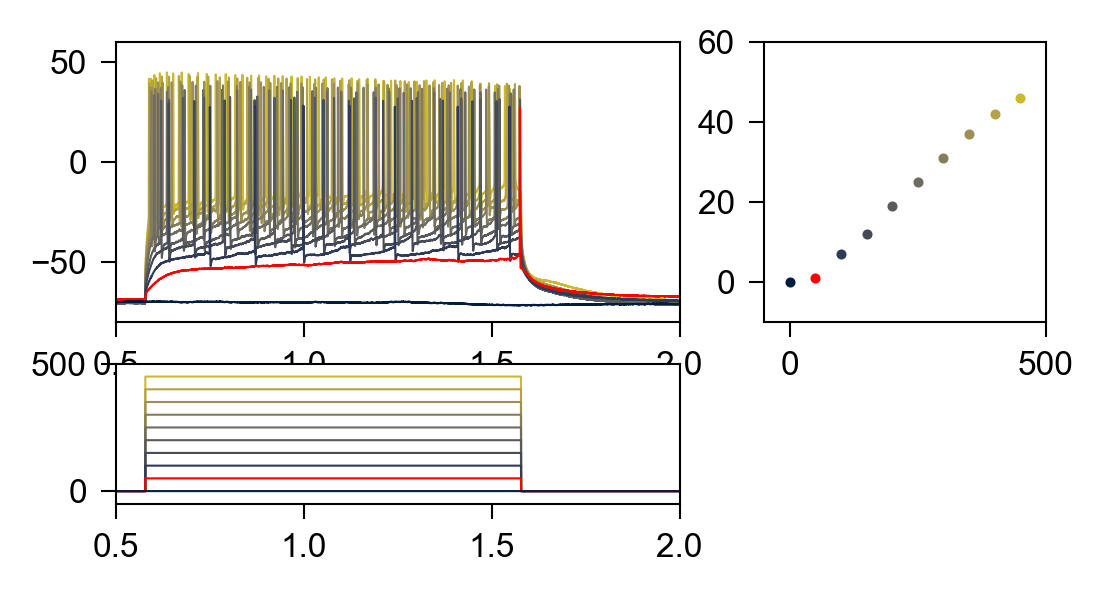

In [21]:
def plot_steps(abf,fig,ax,lw=.5):
    results = {}
    spike_args =  {'spike_thresh':10, 'high_dv_thresh': 25,'low_dv_thresh': -5,'window_ms': 2}
    if len(abf.sweepList)<5: return results # not enough sweeps to analyze

    # Analysis
    spike_results= spikes_per_stim(abf,spike_args, mode='count', to_plot=False)
    stim_currents = spike_results['stim_currents']
    spike_counts = spike_results['spike_counts']
    spike_rates = spike_results['spike_rates']
    v_before_stim = spike_results['v_before_stim']
    fire_dur = spike_results['fire_dur']
    isi_rates = spike_results['isi_rates']
    spike_times = spike_results['spike_times']

    rheo_ind = list(np.diff(spike_counts,prepend=0)>0).index(True)
    print(rheo_ind)


    ## Plotting
    is_base, is_stim = protocol_baseline_and_stim(abf) # find base lines and stims
    colors = plt.cm.cividis(np.linspace(0,1,len(abf.sweepList)))
    for s in abf.sweepList[::-1]:
        abf.setSweep(s)
        dim = .8
        stim_color = np.array(colors[s])*[dim,dim,dim,1]
        if s ==  rheo_ind: stim_color='r'
        print(stim_color)

        time = abf.sweepX
        cmd = abf.sweepC
        memb = abf.sweepY
        memb = memb-memb[0]-70

        ax[2].plot(time,cmd,color=stim_color,linewidth=lw)
        ax[0].plot(time,memb,color=stim_color,linewidth=lw)
        ax[1].scatter(stim_currents[s],spike_counts[s],color=stim_color,s=2)

    return None



from matplotlib.gridspec import GridSpec

abf = abf_or_name(filename)
fig,ax = plt.subplots(2,2,figsize=(4,2),width_ratios=(3,1.5),height_ratios=(2,1),dpi=300)
ax=ax.flatten()
ax[-1].set_visible(False)



v_range = [-80,60]
t_range = [0.5,2]
i_range = [-50,500]
f_range = [-10,60]

ax[0].set_xlim(t_range)
ax[0].set_ylim(v_range)
ax[2].set_xlim(t_range)
ax[2].set_ylim(i_range)
ax[1].set_xlim(i_range)
ax[1].set_ylim(f_range)
plot_steps(abf,fig,ax)
